In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from mpl_toolkits import mplot3d
plt.rcParams['figure.figsize'] = [6.4,4.8]

# Force network to output values in double format
tf.keras.backend.set_floatx('float64')

In [2]:
# Define the number of sigmoid activations in the hidden layer
H = 16

# 2 inputs -> 10 hidden sigmoids -> 1 linear output
inp1 = layers.Input(shape=(1,))
inp2 = layers.Input(shape=(1,))
inp = layers.Concatenate()([inp1,inp2])

hid = layers.Dense(H, activation = 'sigmoid', kernel_initializer = 'glorot_normal')(inp)
out = layers.Dense(1, activation = 'linear', use_bias = False)(hid)
model6 = keras.models.Model([inp1, inp2], out)

# Show the model; the output layer has no bias, therefore, 10 weights only
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 16)           48          ['concatenate[0][0]']        

In [3]:
# Endpoints x0, x1, y0, y1
# N+2=10 grid points along each axis; 100 points in total
x0 = 0
x1 = 1
y0 = 0
y1 = 1
N = 8
hx = (x1-x0)/(N+1)
hy = (y1-y0)/(N+1)

# x holds the grid points to be used as input data
x = np.zeros((10,10,2))
for i in range(N+2):
    for j in range(N+2):
        x[i,j,0] = x0 + i*hx
        x[i,j,1] = y0 + j*hy

# Remake the input data as a numpy array with shape = (100,2)
input_data = np.reshape(x,(100,2)).astype(np.float64)

In [4]:
def trainStep(x,y,opt):
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Middle gradient for second derivative of N wrt x
        with tf.GradientTape() as tape1:
            tape1.watch(x), tape1.watch(y)
            
            # Inner gradient for first derivative of N wrt x
            with tf.GradientTape() as tape2:
                tape2.watch(x), tape2.watch(y)
            
                N = model6([x,y])
            
            [Nx, Ny] = tape2.gradient(N, [x, y])
        [Nxx, Nyy] = tape1.gradient(Nx, [x, y])
         
        # Plug trial solution into PDE:
        eqn = (#(dA/dx)^2
                 (1-y)*(-108/5*np.exp(-3*x/5)*x*np.cos(9*x**2)+9/25*np.exp(-3*x/5)*np.sin(9*x**2)+
                 np.exp(-3*x/5)*(18*np.cos(9*x**2)-324*x**2*np.sin(9*x**2)))+
                 y*(-108/5*np.exp(0.2*(-1-3*x))*x*np.cos(1+9*x**2)+9/25*np.exp(0.2*(-1-3*x))*np.sin(1+9*x**2)+
                 np.exp(0.2*(-1-3*x))*(18*np.cos(1+9*x**2)-324*x**2*np.sin(1+9*x**2)))
               #(dA/dy)^2
                 -2/5*np.exp(-y/5)*(1-x)*np.cos(y)-2/5*np.exp(0.2*(-3-y))*x*np.cos(9+y)-
                 24/25*np.exp(-y/5)*(1-x)*np.sin(y)-24/25*np.exp(0.2*(-3-y))*x*np.sin(9+y)
               #(d/dx)^2 (x(1-x)y(1-y)psi)
                 -y*(1-y)*N+(1-x)*y*(1-y)*Nx-
                 y*(1-y)*N-x*y*(1-y)*Nx+(1-x)*y*(1-y)*Nx-x*y*(1-y)*Nx+x*(1-x)*y*(1-y)*Nxx
               #(d/dy)^2 (x(1-x)y(1-y)psi)
                 -x*(1-x)*N+x*(1-x)*(1-y)*Ny-x*(1-x)*N-x*y*(1-x)*Ny+x*(1-x)*(1-y)*Ny
                 -x*y*(1-x)*Ny+x*(1-x)*y*(1-y)*Nyy
               #-f(x,y)
                -np.exp(-(3*x+y)/5)*((-4/5*3**3*x-2/5+2*3**2)*np.cos(9*x**2+y)+
                 (1/25-1-4*3**4*x**2+3**2/25)*np.sin(9*x**2+y))
               )
        
        loss = tf.reduce_mean(tf.square(eqn)) 
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model6.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model6.trainable_variables))
    
    return loss

In [5]:
def PINNtrain(x, epochs):
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam(lr)
    
    # Define an empty numpy array to hold the loss at each epoch
    epoch_loss = np.zeros(epochs)
        
    # Splits the data into batches of size batch_size
    batch_size = 50
    data_sample = tf.data.Dataset.from_tensor_slices(input_data)
    data_sample = data_sample.cache().shuffle(100).batch(batch_size)
    
    # ds is made to hold the batches and prefetch minimizes the step time
    ds = tf.data.Dataset.zip((data_sample))
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  
    # Main training loop
    for i in range(epochs):
        
        # Iterate over the batches in ds
        for j in ds:
            
            # Compute the loss at the given batch and add to the total loss in the epoch
            x = j[:,0]
            y = j[:,1]
            PDEloss = trainStep(x,y, opt)
            epoch_loss[i] += PDEloss
        
        # Print the loss at each epoch
        if np.mod(i, 100)==0 or i == 9999:
          print("PDE loss in {}th epoch: {: 1.4e}.".format(i, epoch_loss[i]))
    
    return epoch_loss

In [6]:
epochs = 10000
loss = PINNtrain(input_data, epochs)

PDE loss in 0th epoch:  5.8728e+01.
PDE loss in 100th epoch:  5.7392e+01.
PDE loss in 200th epoch:  5.7391e+01.
PDE loss in 300th epoch:  3.6326e+01.
PDE loss in 400th epoch:  2.5226e+00.
PDE loss in 500th epoch:  2.0977e+00.
PDE loss in 600th epoch:  1.8589e+00.
PDE loss in 700th epoch:  1.8045e+00.
PDE loss in 800th epoch:  1.6584e+00.
PDE loss in 900th epoch:  1.6710e+00.
PDE loss in 1000th epoch:  1.5352e+00.
PDE loss in 1100th epoch:  1.3472e+00.
PDE loss in 1200th epoch:  1.2248e+00.
PDE loss in 1300th epoch:  1.1286e+00.
PDE loss in 1400th epoch:  1.0668e+00.
PDE loss in 1500th epoch:  1.0125e+00.
PDE loss in 1600th epoch:  1.1460e+00.
PDE loss in 1700th epoch:  7.7017e-01.
PDE loss in 1800th epoch:  6.6770e-01.
PDE loss in 1900th epoch:  1.4888e+00.
PDE loss in 2000th epoch:  5.2454e-01.
PDE loss in 2100th epoch:  5.1076e-01.
PDE loss in 2200th epoch:  4.2256e-01.
PDE loss in 2300th epoch:  4.0740e-01.
PDE loss in 2400th epoch:  4.4917e-01.
PDE loss in 2500th epoch:  3.3137e-01

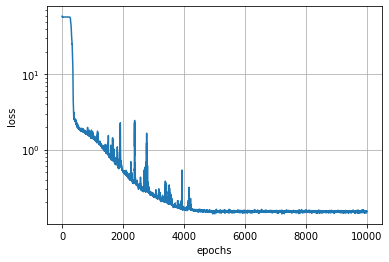

In [7]:
plt.semilogy(range(0, epochs), loss)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid()
plt.savefig('PML2loss')
plt.show()

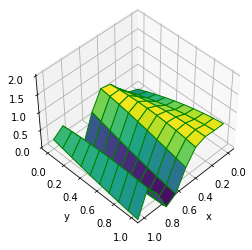

In [8]:
x = np.outer(np.linspace(0,1,10), np.ones(10))
y = x.copy().T
z_true = np.exp((-3*x-y)/5)*np.sin(9*x**2+y)

# Plot exact solution
fig = plt.figure()
ax = plt.axes(projection = '3d')

ax.plot_surface(x,y,z_true,cmap='viridis',edgecolor = 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(0,2)
ax.view_init(45,45)
plt.show()

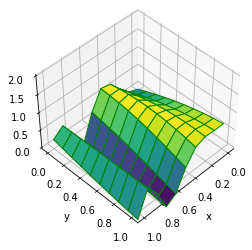

In [9]:
term_1 = ((1-x)*np.exp(-y/5)*np.sin(y)+x*np.exp((-3-y)/5)*np.sin(9+y)+
         (1-y)*(np.exp(-3*x/5)*np.sin(9*x**2)-x*np.exp(-3/5)*np.sin(9))+
         y*(np.exp((-3*x-1)/5)*np.sin(9*x**2+1)-((1-x)*np.exp(-1/5)*np.sin(1)+
                                                x*np.exp(-4/5)*np.sin(10))))

x = x.reshape(100,1)
y = y.reshape(100,1)
term_2 = x*(1-x)*y*(1-y)*model6([x,y])
term_2 = term_2.numpy().reshape(10,10)

x = x.reshape(10,10)
y = y.reshape(10,10)
z_pred = term_1 + term_2

# Plot trial solution
fig = plt.figure()
ax = plt.axes(projection = '3d')

ax.plot_surface(x,y,z_pred,cmap='viridis',edgecolor = 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(0,2)
ax.view_init(45,45)
plt.savefig('PML2pred')
plt.show()

0.1490513184931841


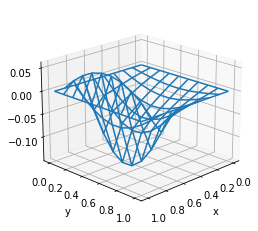

In [10]:
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot_wireframe(x,y,z_true-z_pred)

#Plot l_inf err
print(max(abs(z_true.flatten()-z_pred.flatten())))

ax.view_init(20,45)
plt.savefig('PML2err')
plt.show()